# Using CMA-ME to Land a Lunar Lander Like a Space Shuttle

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

In the [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment, an agent controls a spaceship to touch down gently within a goal zone near the bottom of the screen. Typically, agents in Lunar Lander take a direct approach, hovering straight down:

In [1]:
from IPython.display import display, HTML
display(HTML("""<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-vertical.mp4" type="video/mp4" /></video>"""))

Of course, this works fine, and the lander safely lands on the landing pad. However, there are many (and more theatric) ways we can safely achieve our goal. For instance, a different solution is to land like a space shuttle:

In [2]:
display(HTML("""<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-left.mp4" type="video/mp4" /></video>"""))

And we can also approach from the right:

In [3]:
display(HTML("""<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-right.mp4" type="video/mp4" /></video>"""))

The primary difference between these trajectories is their "point of impact," that is, the $x$-position of the lander when one of its legs hits the ground for the first time. In the vertical trajectory, the lander first impacts the ground at $x \approx -0.1$, and when approaching from the left and right, it first impacts at $x \approx -0.5$ and $x \approx 0.6$, respectively.

Though these trajectories look different, they all achieve good performance (200+), leading to an important insight: there are characteristics of a lunar lander that are not necessarily important for performance, but nonetheless determine the behavior of the lander. In quality diversity (QD) terms, we call these measures. In this tutorial, we will search for policies that yield different trajectories using the pyribs implementation of the QD algorithm [CMA-ME](https://arxiv.org/abs/1912.02400).

**_By the way: Recent work introduced [CMA-MAE](https://arxiv.org/abs/2205.10752), an algorithm which builds on CMA-ME and achieves higher performance in a variety of domains. Once you finish this tutorial, be sure to check out the [next tutorial](https://docs.pyribs.org/en/latest/tutorials/cma_mae.html) to learn about CMA-MAE._**

## Setup

First, let's install pyribs and Gymnasium. [Gymnasium](https://gymnasium.farama.org) is the successor to [OpenAI Gym](https://www.gymlibrary.dev), which was deprecated in late 2022. We use the visualize extra of pyribs (`ribs[visualize]` instead of just `ribs`) so that we obtain access to the [`ribs.visualize`](https://docs.pyribs.org/en/latest/api/ribs.visualize.html) module.

In [ ]:
%pip install ribs[visualize] gymnasium[box2d]==0.27.0 "moviepy>=1.0.0"

# An uninstalled version of decorator is occasionally loaded. This loads the
# newly installed version of decorator so that moviepy works properly -- see
# https://github.com/Zulko/moviepy/issues/1625
import importlib
import decorator
importlib.reload(decorator)

Now, we import Gymnasium and several utilities.

In [ ]:
import sys
import gymnasium as gym
import multiprocessing
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

## Problem Description

We treat the Lunar Lander as a quality diversity (QD) problem. For the objective, we use the default rewards provided by the environment, which encourages landing on the landing pad and penalizes engine usage.

For the measure functions, we are interested in several factors at the time of "impact." We define impact to be the first time when either of the lunar lander's legs touches the ground. When this happens, we measure the following:

- $x$-position: This will lead to markedly different trajectories, as seen earlier.
- $y$-velocity: Different velocities will determine how hard the lander impacts the ground.

If the lunar lander never impacts the ground, we default the $x$-position to be the last $x$-position of the lander, and the $y$-velocity to be the maximum velocity of the lander (technically minimum since velocities are negative).

We will search for policies that produce high-performing trajectories with these measures. For simplicity, we will use a linear policy to control the lunar lander. As the default lunar lander has discrete controls, the equation for this policy is:

$$a = argmax(Ws)$$

where $a$ is the action to take, $s$ is the state vector, and $W$ is our model, a matrix of weights that stays constant. Essentially, we transform the state to a vector with a "signal" for each possible action in the action space, and we choose the action with the highest signal. To search for a different policy, we explore the space of models $W$.

In this tutorial, we will search for policies solving a fixed scenario with a flat terrain. To create this scenario, we use a fixed seed of 52 in the environment.

**Note: Determinism**

> Since our policy and environment are both deterministic, we only have to simulate the policy once to find its performance. Typically, we would run our policy multiple times to gauge average performance and have it generalize, but we ignore that to keep this example simple.

In [16]:
# Create an environment so that we can obtain information about it.
reference_env = gym.make("LunarLander-v2")
action_dim = reference_env.action_space.n
obs_dim = reference_env.observation_space.shape[0]

# Seed for all environments in this notebook.
env_seed = 52

We can summarize our problem description with the following `simulate` function, which takes in the model and rolls it out in the Lunar Lander environment.

In [15]:
def simulate(model, seed=None, video_env=None):
    """Simulates the lunar lander model.

    Args:
        model (np.ndarray): The array of weights for the linear policy.
        seed (int): The seed for the environment.
        video_env (gym.Env): If passed in, this will be used instead of creating
            a new env. This is used primarily for recording video during
            evaluation.
    Returns:
        total_reward (float): The reward accrued by the lander throughout its
            trajectory.
        impact_x_pos (float): The x position of the lander when it touches the
            ground for the first time.
        impact_y_vel (float): The y velocity of the lander when it touches the
            ground for the first time.
    """
    if video_env is None:
        # Since we are using multiple processes, it is simpler if each worker
        # just creates their own copy of the environment instead of trying to
        # share the environment. This also makes the function "pure." However,
        # we should use the video_env if it is passed in.
        env = gym.make("LunarLander-v2")
    else:
        env = video_env

    action_dim = env.action_space.n
    obs_dim = env.observation_space.shape[0]
    model = model.reshape((action_dim, obs_dim))

    total_reward = 0.0
    impact_x_pos = None
    impact_y_vel = None
    all_y_vels = []
    obs, _ = env.reset(seed=seed)
    done = False

    while not done:
        action = np.argmax(model @ obs)  # Linear policy.
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # Refer to the definition of state here:
        # https://gymnasium.farama.org/environments/box2d/lunar_lander/
        x_pos = obs[0]
        y_vel = obs[3]
        leg0_touch = bool(obs[6])
        leg1_touch = bool(obs[7])
        all_y_vels.append(y_vel)

        # Check if the lunar lander is impacting for the first time.
        if impact_x_pos is None and (leg0_touch or leg1_touch):
            impact_x_pos = x_pos
            impact_y_vel = y_vel

    # If the lunar lander did not land, set the x-pos to the one from the final
    # timestep, and set the y-vel to the max y-vel (we use min since the lander
    # goes down).
    if impact_x_pos is None:
        impact_x_pos = x_pos
        impact_y_vel = min(all_y_vels)

    # Only close the env if it was not a video env.
    if video_env is None:
        env.close()

    return total_reward, impact_x_pos, impact_y_vel

## CMA-ME with pyribs

To train our policy, we will use the CMA-ME algorithm (if you are not familiar with CMA-ME, please refer to the corresponding [paper](https://arxiv.org/abs/1912.02400)). This means we need to import and initialize the `GridArchive`, `EvolutionStrategyEmitter`, and `Scheduler` from pyribs.

### GridArchive

First, the [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html) stores solutions (i.e. models for our policy) in a rectangular grid. Each dimension of the `GridArchive` corresponds to a dimension in measure space that is segmented into equally sized cells. As we have two measure functions for our lunar lander, we have two dimensions in the `GridArchive`. The first dimension is the impact $x$-position, which ranges from -1 to 1, and the second is the impact $y$-velocity, which ranges from -3 (smashing into the ground) to 0 (gently touching down). We divide both dimensions into 50 cells.

We additionally specify the dimensionality of solutions which will be stored in the archive. While each model is a 2D matrix, pyribs archives only allow 1D arrays for efficiency; hence, we create an `initial_model` below and retrieve the size of its flattened, 1D form with `initial_model.size`.

In [8]:
from ribs.archives import GridArchive
initial_model = np.zeros((action_dim, obs_dim))

archive = GridArchive(
    solution_dim=initial_model.size,  # Dimensionality of solutions in the archive.
    dims=[50, 50],  # 50 cells along each dimension.
    ranges=[(-1.0, 1.0), (-3.0, 0.0)],  # (-1, 1) for x-pos and (-3, 0) for y-vel.
    qd_score_offset=-600,  # See the note below.
)

**Note: QD Score Offset**

> Above, we specified `qd_score_offset=-600` when initializing the archive. The QD score ([Pugh 2016](https://doi.org/10.3389/frobt.2016.00040)) is a metric for QD algorithms which sums the objective values of all elites in the archive. However, if objectives can be negative, this metric will penalize an algorithm for discovering new cells with a negative objective. To prevent this, it is common to normalize each objective to be non-negative by subtracting an offset, typically the minimum objective, before computing the QD score. While lunar lander does not have a predefined minimum objective, we know from previous experiments that almost all solutions score above -600, so we have set the offset accordingly. Thus, if a solution has, for example, an objective of -300, then its objective will be normalized to -300 - (-600) = 300.

### EvolutionStrategyEmitter

Next, the [`EvolutionStrategyEmitter`](https://docs.pyribs.org/en/latest/api/ribs.emitters.EvolutionStrategyEmitter.html) with two-stage improvement ranking ("2imp") uses CMA-ES to search for policies that add new entries to the archive or improve existing ones. Since we do not have any prior knowledge of what the model will be, we set the initial model to be the zero vector, and we set the initial step size for CMA-ES to be 1.0, so that initial solutions are sampled from a standard isotropic Gaussian. Furthermore, we use 5 emitters so that the algorithm simultaneously searches several areas of the measure space.

In [9]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive=archive,
        x0=initial_model.flatten(),
        sigma0=1.0,  # Initial step size.
        ranker="2imp",
        batch_size=30,  # If we do not specify a batch size, the emitter will
                        # automatically use a batch size equal to the default
                        # population size of CMA-ES.
    ) for _ in range(5)  # Create 5 separate emitters.
]

**Note: Two-Stage Improvement Ranking**

> The term "two-stage" refers to how this ranking mechanism ranks solutions by a tuple of `(status, value)` defined as follows:
>
> 1. `status`: Whether the solution creates a new cell in the archive, improves an existing cell, or is not inserted.
> 2. `value`: Consider the objective $f$ of the solution and the objective $f'$ of the solution currently in the cell where the solution will be inserted. When the solution creates a new cell, $f'$ is undefined because the cell was previously empty, so the value is defined as $f$. Otherwise, when the solution improves an existing cell or is not inserted at all, the value is $f - f'$.
>
> During ranking, this two-stage improvement ranker will first sort by `status`, prioritizing new solutions, followed by solutions which improve existing cells, followed by solutions which are not inserted. Within each group, solutions are further ranked by their corresponding `value`. See the archive [`add`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.add) method for more information on statuses and values.
> 
> Additional rankers are available in the [ribs.emitters.rankers](https://docs.pyribs.org/en/latest/api/ribs.emitters.rankers.html) module. These rankers include those corresponding to different emitters described in the CMA-ME paper.

### Scheduler

Finally, the [`Scheduler`](https://docs.pyribs.org/en/latest/api/ribs.schedulers.Scheduler.html) controls how the emitters interact with the archive. On every iteration, the scheduler calls the emitters to generate solutions. After the user evaluates these generated solutions, the scheduler inserts the solutions into the archive and passes the feedback to the emitters (this feedback consists of the `status` and `value` for each solution that we described in the note above).

In [10]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

## QD Search

With the pyribs components defined, we start searching with CMA-ME. Since we use 5 emitters each with a batch size of 30 and we run 250 iterations, we run 5 x 30 x 250 = 37,500 lunar lander simulations. We also keep track of some logging info via `archive.stats`, which is an [`ArchiveStats`](https://docs.pyribs.org/en/latest/api/ribs.archives.ArchiveStats.html) object.

To speed up this loop, we parallelize the evaluation of multiple solutions with Python's [multiprocessing module](https://docs.python.org/3/library/multiprocessing.html), specifically the [`starmap`](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool.starmap) method of [`multiprocessing.Pool`](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool). With two workers, the loop should take **2 hours** to run. With two workers, it should take **1 hour** to run. Feel free to increase the number of workers based on what your system has available to speed up the loop further.

In [11]:
start_time = time.time()
total_itrs = 250
workers = 2  # Adjust the number of workers based on what you have available.

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    # Request models from the scheduler.
    sols = scheduler.ask()

    # Evaluate the models and record the objectives and measuress.
    with multiprocessing.Pool(workers) as pool:
        results = pool.starmap(simulate, [(model, env_seed) for model in sols])

    objs, meas = [], []
    for obj, impact_x_pos, impact_y_vel in results:
        objs.append(obj)
        meas.append([impact_x_pos, impact_y_vel])

    # Send the results back to the scheduler.
    scheduler.tell(objs, meas)

    # Logging.
    if itr % 25 == 0:
        tqdm.write(f"> {itr} itrs completed after {time.time() - start_time:.2f}s")
        tqdm.write(f"  - Size: {archive.stats.num_elites}")    # Number of elites in the archive. len(archive) also provides this info.
        tqdm.write(f"  - Coverage: {archive.stats.coverage}")  # Proportion of archive cells which have an elite.
        tqdm.write(f"  - QD Score: {archive.stats.qd_score}")  # QD score, i.e. sum of objective values of all elites in the archive.
                                                               # Accounts for qd_score_offset as described in the GridArchive section.
        tqdm.write(f"  - Max Obj: {archive.stats.obj_max}")    # Maximum objective value in the archive.
        tqdm.write(f"  - Mean Obj: {archive.stats.obj_mean}")  # Mean objective value of elites in the archive.

> 25 itrs completed after 258.67s                                        
  - Size: 1080                                                           
  - Coverage: 0.432                                                      
  - QD Score: 474862.76574713085                                         
  - Max Obj: 304.1126503737456                                           
  - Mean Obj: -160.31225393784183                                        
> 50 itrs completed after 630.38s                                        
  - Size: 1665                                                           
  - Coverage: 0.666                                                      
  - QD Score: 769090.5399268053                                          
  - Max Obj: 304.33805483776115                                          
  - Mean Obj: -138.08375980372057                                        
> 75 itrs completed after 900.36s                                        
  - Size: 2029                        

## Visualizing the Archive

Using [`grid_archive_heatmap`](https://docs.pyribs.org/en/latest/api/ribs.visualize.grid_archive_heatmap.html) from the [`ribs.visualize`](https://docs.pyribs.org/en/latest/api/ribs.visualize.html) module, we can view a heatmap of the archive. The heatmap shows the measures for which CMA-ME found a solution. The color of each cell shows the objective value of the solution.

Text(0.5, 0, 'Impact x-position')

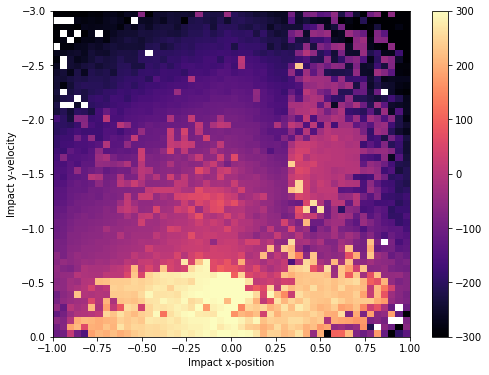

In [12]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=-300, vmax=300)
plt.gca().invert_yaxis()  # Makes more sense if larger velocities are on top.
plt.ylabel("Impact y-velocity")
plt.xlabel("Impact x-position")

From this heatmap, we can make a few observations:

- CMA-ME found solutions for all cells in the archive (empty cells would show up as white).
- Most of the high-performing solutions have lower impact $y$-velocities (see the bright area at the bottom of the map). This is reasonable, as a lander that crashes into the ground would not do well.
- The high-performing solutions are spread across a wide range of impact $x$-positions. The highest solutions seem to be at $x \approx 0$ (the bright spot in the middle). This makes sense since an impact $x$-position of 0 corresponds to the direct vertical approach. Nevertheless, there are many high-performing solutions that had other $x$-positions, and we will visualize them in the next section.

## Visualizing Individual Trajectories

To view the trajectories for different models, we can use the [RecordVideo](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo) wrapper, and we can use IPython to display the video in the notebook. The `display_video` function below shows how to do this.

In [17]:
import base64
import glob
import io

from IPython.display import display, HTML


def display_video(model):
    """Displays a video of the model in the environment."""

    video_env = gym.wrappers.RecordVideo(
        gym.make("LunarLander-v2", render_mode="rgb_array"),
        video_folder="videos",
        # This will ensure all episodes are recorded as videos.
        episode_trigger=lambda idx: True,
        # Disables moviepy's logger to reduce clutter in the output.
        disable_logger=True,
    )
    simulate(model, env_seed, video_env)
    video_env.close()  # Save video.

    # Display the video with HTML. Though we use glob, there is only 1 video.
    for video_file in glob.glob("videos/*.mp4"):
        video = io.open(video_file, 'rb').read()
        encoded = base64.b64encode(video).decode("ascii")
        display(
            HTML(f'''
            <video width="360" height="auto" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>'''))


We can retrieve policies with measures that are close to a query with the [`retrieve_single`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.retrieve_single) method. This method will look up the cell corresponding to the queried measures. Then, the method will check if there is an elite in that cell, and return the elite if it exists (the method does not check neighboring cells for elites). The returned elite may not have the exact measures requested because the elite only has to be in the same cell as the queried measures.

Below, we first retrieve a policy that impacted the ground on the left (approximately -0.4) with low velocity (approximately -0.10) by querying for `[-0.4, 0.10]`.

In [18]:
elite = archive.retrieve_single([-0.4, -0.10])
# NaN objective indicates the solution could not be retrieved because there was
# no elite in the corresponding cell.
if not np.isnan(elite.objective):
    print(f"Objective: {elite.objective}")
    print(f"Measures: (x-pos: {elite.measures[0]}, y-vel: {elite.measures[1]})")
    display_video(elite.solution)

Objective: 261.2776277190984
Measures: (x-pos: -0.38308459520339966, y-vel: -0.07349591702222824)


We can also find a policy that impacted the ground on the right (0.8) with low velocity.

**Note: Batch and Single Methods**

> `retrieve_single` returns an [Elite](https://docs.pyribs.org/en/latest/api/ribs.archives.Elite.html) object given a single `measures` array. Meanwhile, the [`retrieve`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.retrieve) method takes in a _batch_ of measures (named `measures_batch`) and returns an [EliteBatch](https://docs.pyribs.org/en/latest/api/ribs.archives.EliteBatch.html) object. Several archive methods in pyribs follow a similar pattern of having a batch and single version, e.g., [`add`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.add) and [`add_single`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.add_single).

In [30]:
elite = archive.retrieve_single([0.8, -0.10])
if not np.isnan(elite.objective):
    print(f"Objective: {elite.objective}")
    print(f"Measures: (x-pos: {elite.measures[0]}, y-vel: {elite.measures[1]})")
    display_video(elite.solution)

Objective: 170.09914509102816
Measures: (x-pos: 0.48498544096946716, y-vel: -0.10281097143888474)


And we can find a policy that executes a regular vertical landing, which happens when the impact $x$-position is around 0.

In [20]:
elite = archive.retrieve_single([0.0, -0.10])
if not np.isnan(elite.objective):
    print(f"Objective: {elite.objective}")
    print(f"Measures: (x-pos: {elite.measures[0]}, y-vel: {elite.measures[1]})")
    display_video(elite.solution)

Objective: 293.9520321261102
Measures: (x-pos: 0.009707164950668812, y-vel: -0.08807709068059921)


As the archive has ~2500 solutions, we cannot view them all, but we can filter for high-performing solutions. We first retrieve the archive's elites with the [`as_pandas`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.as_pandas) method. Then, we choose solutions that scored above 200 because 200 is the [threshold for the problem to be considered solved](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Note that many high-performing solutions do not land on the landing pad.

In [21]:
df = archive.as_pandas()
high_perf_sols = df.query("objective > 200").sort_values("objective", ascending=False)

Below we visualize several of these high-performing solutions. The `iterelites` method is available because `as_pandas` returns an [`ArchiveDataFrame`](https://docs.pyribs.org/en/latest/api/ribs.archives.ArchiveDataFrame.html), a subclass of the Pandas DataFrame specialized for pyribs. `iterelites` iterates over the entries in the DataFrame and returns them as [`Elite`](https://docs.pyribs.org/en/latest/api/ribs.archives.Elite.html) objects.

In [22]:
if len(high_perf_sols) > 0:
    for elite in high_perf_sols.iloc[[0, len(high_perf_sols) // 2, -1]].iterelites():
        print(f"Objective: {elite.objective}")
        print(f"Measures: (x-pos: {elite.measures[0]}, y-vel: {elite.measures[1]})")
        display_video(elite.solution)

Objective: 312.2276673158835
Measures: (x-pos: -0.09034957736730576, y-vel: -0.46454182267189026)


Objective: 248.7148539253435
Measures: (x-pos: 0.4014013409614563, y-vel: -1.165602445602417)


Objective: 200.3360757205378
Measures: (x-pos: 0.48762187361717224, y-vel: -0.02384234592318535)


And finally, the [`best_elite`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.best_elite) property is the [`Elite`](https://docs.pyribs.org/en/latest/api/ribs.archives.Elite.html) which has the highest performance in the archive.

In [23]:
print(f"Objective: {archive.best_elite.objective}")
print(f"Measures: (x-pos: {archive.best_elite.measures[0]}, y-vel: {archive.best_elite.measures[1]})")
display_video(archive.best_elite.solution)

Objective: 312.2276673158835
Measures: (x-pos: -0.09034957736730576, y-vel: -0.46454182267189026)


## Conclusion

As the saying goes, "there is more than one way to land an airplane" 😉. However, it is often difficult to shape the reward function in reinforcement learning to discover these unique and "creative" solutions. In such cases, a QD algorithm can help search for solutions that vary in "interestingness."

In this tutorial, we showed that this is the case for the lunar lander environment. Using CMA-ME, we searched for lunar lander trajectories with differing impact measures. Though these trajectories all take a different approach, many perform well.

For extending this tutorial, we suggest the following:

- Replace the impact measures with your own measures. What other properties might be interesting for the lunar lander?
- Try different terrains by changing the seed. For instance, if the environment has valleys, can the lander learn to go into this valley and glide back up?
- Use other gym environments. What measures could you use in an environment like `BipedalWalker-v2`?

Finally, to learn about an algorithm which performs even better on QD problems, check out the [CMA-MAE tutorial](https://docs.pyribs.org/en/latest/tutorials/cma_mae.html).

And for a version of this tutorial that uses [Dask](https://dask.org) to parallelize evaluations and thus speed things up, refer to the [Lunar Lander example](https://docs.pyribs.org/en/latest/examples/lunar_lander.html).

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_lunar_lander,
  title   = {Using CMA-ME to Land a Lunar Lander Like a Space Shuttle},
  author  = {Bryon Tjanaka and Sam Sommerer and Nikitas Klapsis and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2021},
  url     = {https://docs.pyribs.org/en/stable/tutorials/lunar_lander.html}
}
```

## Credits

This tutorial is based on a [poster](https://web.archive.org/web/20220817214422/https://1l7puj10vwe3zflo2jsktkit-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/S20-Klapsis-Poster.pdf) created by Nikitas Klapsis as part of USC's 2020 SHINE program.